In [112]:
# Random Forest Regressor
# Needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 

In [113]:
# Takes the csv file and converts it into a dataframe
df = pd.read_csv('/Users/dimitrishort/Documents/DataMiningFinal/ProcessedMovieData.csv')

# Creates a second dataframe to preserve values 
df_original = pd.read_csv('/Users/dimitrishort/Documents/DataMiningFinal/ProcessedMovieData.csv')

# Displays the first few rows of the dataframe 
df.head()

,userId,movieId,rating,title,genres,datetime,year,month,day,dayofweek,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,1,0.777778,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2000-07-30 18:45:03,2000,7,30,6,...,0,0,0,0,0,0,0,0,0,1995.0
1,5,1,0.777778,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1996-11-08 06:36:02,1996,11,8,4,...,0,0,0,0,0,0,0,0,0,1995.0
2,7,1,0.888889,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2005-01-25 06:52:26,2005,1,25,1,...,0,0,0,0,0,0,0,0,0,1995.0
3,15,1,0.444444,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2017-11-13 12:59:30,2017,11,13,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,17,1,0.888889,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2011-05-18 05:28:03,2011,5,18,2,...,0,0,0,0,0,0,0,0,0,1995.0


In [114]:
# Remove columns not needed for training 
df = df.drop(['title', 'genres', 'datetime', 'release_year'], axis=1)

# Prepares the features and target
X = df.drop('rating', axis=1)
y = df['rating'] # Sets the target to rating for the model 

# Splits the dataset into training and test sets with 20% for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
estimators_list = [10, 15, 25, 50, 100, 150, 200, 250] # List of n_estimators to test
test_errors = [] # List to store the test errors

# Train and test the RandomForestRegressor with different n_estimators
for n_estimators in estimators_list:
    
    # Initializes RandomForestRegressor with the defined number of trees
    RF = RandomForestRegressor(n_estimators=n_estimators, random_state=1)
    
    RF.fit(X_train, y_train) # Fit the RandomForestRegressor
    y_pred = RF.predict(X_test) # Predicts the test set
    
    # Calculates test error appending it to the error list
    test_errors.append(mean_squared_error(y_test, y_pred))

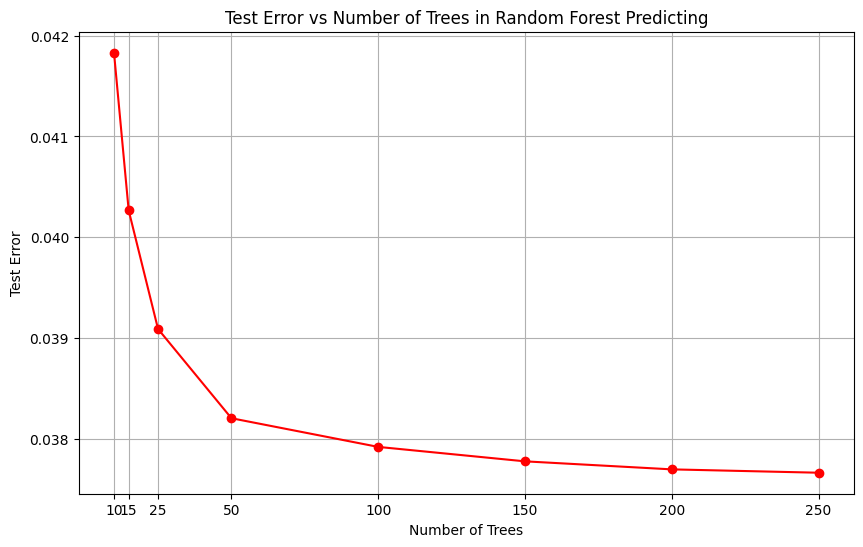

In [116]:
# Plots the relationship between the number of trees in the forest and test error
plt.figure(figsize=(10, 6))
plt.plot(estimators_list, test_errors, marker='o', linestyle='-', color='red')
plt.title('Test Error vs Number of Trees in Random Forest Predicting')
plt.xlabel('Number of Trees')
plt.ylabel('Test Error')
plt.xticks(estimators_list)
plt.grid(True)
plt.show()

In [117]:
def recommend_movies_for_user(user_id, model, data, original_titles_genres, num_recommendations=5):
    # Gets the title and genres from the original dataframe 
    original_titles_genres = df_original[['movieId', 'title', 'genres']].drop_duplicates()
    
    # Gets the movies that the user already rated 
    rated_movies = data[data['userId'] == user_id]['movieId'].unique()
    
    # Gets the movies that haven't been rated by the user 
    unrated_movies = data[~data['movieId'].isin(rated_movies)].drop_duplicates(subset='movieId')
    
    # Prepares the data for the unrated movies by dropping unnecessary columns
    features = unrated_movies.drop(['rating'], axis=1)
    
    # Predicts ratings for the unrated movies from the trained model 
    predicted_ratings = model.predict(features)
    
    # Adds the predicted ratings to the unrated dataframe 
    unrated_movies = unrated_movies.assign(predicted_rating=predicted_ratings)
    
    # Merges the dataframe with original titles and genres
    recommendations = unrated_movies.merge(original_titles_genres, on='movieId', how='left')
    
    # Get the top 5 recommendations based on predicted ratings in descending order 
    top_recommendations = recommendations.nlargest(num_recommendations, 'predicted_rating')

    # Returns the recommended movies 
    return top_recommendations[['movieId', 'title', 'genres', 'predicted_rating']]

# Calls the function to get the predicted movies with a given user 
recommended_movies = recommend_movies_for_user(user_id=1, model=RF, data=df, original_titles_genres=original_titles_genres, num_recommendations=5)
print(recommended_movies) # Prints the recommended movies


      movieId                                  title  \
4192   151769              Three from Prostokvashino   
3725   136341      Scooby-Doo! and the Samurai Sword   
3726   136353  Scooby-Doo! and the Loch Ness Monster   
3728   136359              Scooby-Doo Goes Hollywood   
4197   163112          Winnie the Pooh Goes Visiting   

                         genres  predicted_rating  
4192                  Animation          1.000000  
3725  Animation|Children|Comedy          0.999111  
3726  Animation|Children|Comedy          0.999111  
3728  Animation|Children|Comedy          0.999111  
4197                  Animation          0.999111  


In [ ]:
'''
The recommendations from the Random Forest Regressor tends
to have a strong focus on genres with Animation and Children
along with some Comedy which does align with the user preferences. 
Since the model has a heavy emphasis on these genres, its omitting 
other genres that the user prefers such as Adventure, Action, and
Drama. While these predictions have a high confidence, it appears
that it may be overfitting to these genres as a result. In all, the
model does give somewhat accurate predictions but could be tweaked
to encompass all the prefered genres and not just a few. 
'''